In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Carrega a tabela imortação
imp_fert=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_cat.csv').reset_index(drop=True)
imp_fert.shape

(89785, 11)

In [25]:
imp_fert.head(1)

,year,month,ncm,Product,UF,pais,urf,kg,US$_fob,US$_freight,US$_insurance
0,1997,1,31022100,SAM,GO,23,817800,1900000,184300,19000,0


### Identifica as colunas quantitativas

In [26]:
col_quanti=['kg','US$_fob','US$_freight']
col_quanti

['kg', 'US$_fob', 'US$_freight']

### Avalia impacto e elimina registros com quantidade igual a zero

In [27]:
# Avalia impacto na eliminação de registros com quantidade zero
for q in col_quanti:
    print(f"{q} possui {round(100*imp_fert[imp_fert[q]==0].shape[0]/imp_fert.shape[0],1)} % dos registros com valor igual a zero.")

kg possui 0.0 % dos registros com valor igual a zero.
US$_fob possui 0.0 % dos registros com valor igual a zero.
US$_freight possui 0.3 % dos registros com valor igual a zero.


In [28]:
for q in col_quanti:
    par=imp_fert[imp_fert[q]==0][[x for x in col_quanti if x not in [q]]].sum()
    tot=imp_fert[imp_fert[q]!=0][[x for x in col_quanti if x not in [q]]].sum()
    print('Qdo ',q,'= 0:')
    print(f"{100*(par/tot)} % do total.")
    print()

Qdo  kg = 0:
US$_fob        2.237782e-06
US$_freight    6.689952e-09
dtype: float64 % do total.

Qdo  US$_fob = 0:
kg             0.0
US$_freight    0.0
dtype: float64 % do total.

Qdo  US$_freight = 0:
kg         0.000108
US$_fob    0.000101
dtype: float64 % do total.



In [29]:
# Seleciona colunas para descate de zero
col_quanti=[x for x in col_quanti if x not in ['VL_SEGURO']]
col_quanti

['kg', 'US$_fob', 'US$_freight']

In [30]:
# Descarta registros com valor igual a zero
for c in col_quanti:
    imp_fert=imp_fert[imp_fert[c]>0]

### Corrige inflação monetária

In [31]:
# Carrega função de correção do dólar
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/corrige_inflação_dólar.ipynb'


Função ***corrige_inflação_dólar(df_ano_mes_valor,col_vl_name)*** disponível.



In [32]:
# Identifica valores a serem corrigidos da inflação
col_val=[x for x in imp_fert.columns if x[:2]=='VL']
col_val

[]

In [33]:
# Salva backup e corrige inflação
for cv in col_val:
    imp_fert.insert(7,cv+'_orig',imp_fert[cv])
    imp_fert=corrige_inflação_dólar(imp_fert,cv)

In [34]:
imp_fert.columns

Index(['year', 'month', 'ncm', 'Product', 'UF', 'pais', 'urf', 'kg', 'US$_fob',
       'US$_freight', 'US$_insurance'],
      dtype='object')

sns.displot(kind='kde',data=imp_fert.sort_values('Product'),x='kg',col='Product',col_wrap=3,height=2,aspect=2,\
            log_scale=True,facet_kws=dict(sharey=False,sharex=False))

plt.show()

## Clusteriza NCM

In [35]:
imp_fert['log_kg']=np.log10(imp_fert.kg)
imp_fert['log_fob']=np.log10(imp_fert['US$_fob'])
imp_fert['log_frete']=np.log10(imp_fert['US$_freight'])
imp_fert['cif_kg']=(imp_fert['US$_fob']+imp_fert['US$_freight'])/imp_fert.kg
imp_fert['fob_kg']=(imp_fert['US$_fob'])/imp_fert.kg

In [36]:
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/clusteriza_ncm.ipynb'

** Função clusteriza_ncm(imp_fert, n_clusters=4, cols_base=['s_log_kg','s_log_fob']) disponível **


In [37]:
n_cluster_list=[1,3,3,
                3,2,1,
                6,2,2,
                5,3,2,
                2,3,2,
                2,2,4,
                1,3,2,
                5,1,1,
                1,2,4]
ncm_list=imp_fert['Product'].drop_duplicates().sort_values().values
d=dict(zip(ncm_list,n_cluster_list))

In [38]:
imp_fert.Product.unique()

array(['SAM', 'Outros nitratos de sódio', 'Outros N', 'MOP<60', 'MOP',
       'SOP<52', 'NPK', 'Nit.Sódio Potássico 15 15', 'NK', 'UREIA', 'NAM',
       'Nit.Sódio natural<16,3', 'Superfosfatos<22', 'Outros potássicos',
       'MAP', 'Outros Nit.Sódio potássico', 'Ureia, mesmo aquosa', 'NCa',
       'Superfosfato>45', 'Outros SOP', 'DAP arsênio> 6 mg/kg', 'PK',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [39]:
q=pd.DataFrame()
for n in ncm_list:
    t=imp_fert[imp_fert.Product==n]
    t=clusteriza_ncm(t,n_clusters=d[n],cols_base=['log_kg','log_fob','log_frete','cif_kg','fob_kg'])
    q=pd.concat([q,t])

In [40]:
imp_fert=q

In [41]:
imp_fert[(imp_fert.Product=='MAP')&(imp_fert.km==1)].kg.min()

np.int64(987)

sns.displot(kind='kde', data=imp_fert, x='kg', col='Product', hue='km', col_wrap=3, height=2, aspect=2,\
            log_scale=True, facet_kws=dict(sharey=False)).fig.suptitle('Brazilian Fertilizers Imports', y=1.05)

#plt.savefig('/home/andre301267/git/Pricing-Fertilizer/DB/Comexstat/graphs/fertilizers_imports.png')
plt.show()

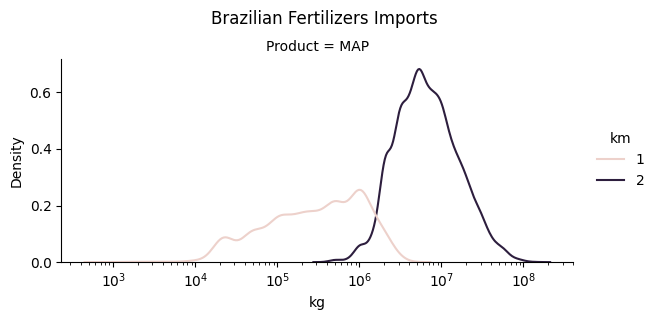

In [42]:
sns.displot(kind='kde', data=imp_fert[(imp_fert.Product=='MAP')&(imp_fert.km!=0)], x='kg', col='Product', hue='km',\
             height=3, aspect=2, log_scale=True)\
                .fig.suptitle('Brazilian Fertilizers Imports', y=1.05)

plt.savefig('/home/andre301267/git/Pricing-Fertilizer/DB/Comexstat/graphs/fertilizers_imports.png')
plt.show()

### Corrige outliers através do preço

Confere maior registro de peso:

In [43]:
imp_fert[imp_fert.kg==imp_fert.kg.max()]

,s_fob_kg,s_cif_kg,s_log_frete,s_log_fob,s_log_kg,year,month,ncm,Product,UF,...,kg,US$_fob,US$_freight,US$_insurance,log_kg,log_fob,log_frete,cif_kg,fob_kg,km
1118,0.0,0.0,0.811266,0.852084,1.0,2003,8,31021010,UREIA,BA,...,1418071545,5604808,293995,0,9.151698,6.748561,5.46834,0.00416,0.003952,1


Confere a soma geral

In [44]:
imp_fert[['kg','US$_fob']].sum()/10**9

kg         556.772041
US$_fob    178.211995
dtype: float64

Carrega função para correção via preço

In [45]:
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/corr_kg_fob_via_preço.ipynb'

** Função corr_kg_fob_via_preço(imp_fert,z=3) disponível **


Corrige

q=pd.DataFrame()
z=3
k=0
f=0
for ncm in imp_fert.ncm.unique():
    for km in imp_fert.km.unique():
        t=imp_fert[(imp_fert.ncm==ncm)&(imp_fert.km==km)]
        t, len_err_kg, len_err_fob=corr_kg_fob_via_preço(t,z)
        q=pd.concat([q,t])
        k+=len_err_kg
        f+=len_err_fob

print(f"Através do preço, foram corrigidos {k} registros de kg e {f} registros de valor fob, que estavam a mais de {z} vezes \
o desvio padrão\nde distância da média (z score).")

imp_fert=q.copy()

Confere maior registro de peso:

In [46]:
imp_fert[imp_fert.kg==imp_fert.kg.max()]

,s_fob_kg,s_cif_kg,s_log_frete,s_log_fob,s_log_kg,year,month,ncm,Product,UF,...,kg,US$_fob,US$_freight,US$_insurance,log_kg,log_fob,log_frete,cif_kg,fob_kg,km
1118,0.0,0.0,0.811266,0.852084,1.0,2003,8,31021010,UREIA,BA,...,1418071545,5604808,293995,0,9.151698,6.748561,5.46834,0.00416,0.003952,1


Confere a soma geral

In [48]:
imp_fert[['kg','US$_fob']].sum()/10**9

kg         556.772041
US$_fob    178.211995
dtype: float64

In [51]:
imp_fert.to_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_quanti.csv',index=False)